In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import re
import pickle
import json
import random
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
from tqdm.auto import tqdm

from transformers import MT5TokenizerFast

from CwnGraph import CwnImage
import vec4gloss
from vec4gloss import check_hashes
from vec4gloss import Vec4GlossModel

## Data dependencies
```
..\data\annotation.json 2ed250
..\data\models\vec4gloss-defgen-220629-1250\pytorch_model.bin 9f894f
```

In [3]:
vec4gloss_model_dir = "../data/models/vec4gloss-defgen-220629-1250"
_ = check_hashes([
    "../data/annotation.json",
    vec4gloss_model_dir + "/pytorch_model.bin",
])

..\data\annotation.json 2ed250
..\data\models\vec4gloss-defgen-220629-1250\pytorch_model.bin 9f894f


## Loading resources

In [4]:
annot_data = json.loads(Path("../data/annotation.json").read_text(encoding="UTF-8"))

In [5]:
len(annot_data), annot_data[45]

(288,
 {'sense_id': 3048001,
  'head_word': '沿街',
  'POS': 'D',
  'definition': '表同一事件在經過的街道中重複發生。',
  'event_role': 'agent',
  'schemas': [{'type': 'event', 'start': 1, 'end': 5},
   {'type': 'scope', 'start': 5, 'end': 6},
   {'type': 'place', 'start': 6, 'end': 11},
   {'type': 'scope', 'start': 11, 'end': 12},
   {'type': 'mod', 'start': 12, 'end': 14},
   {'type': 'action', 'start': 14, 'end': 16}]})

In [6]:
## Loading modem
use_cuda = torch.cuda.is_available() and "GeForce" not in torch.cuda.get_device_name()
device = "cuda" if use_cuda else "cpu"    
print("Using", device)

model = Vec4GlossModel.from_pretrained(vec4gloss_model_dir).to(device)
tokenizer = MT5TokenizerFast.from_pretrained(vec4gloss_model_dir)
gen = vec4gloss.gen_func(tokenizer, model)

Using cpu


In [7]:
CWN_VER = "v.2022.06.21"
cwn = CwnImage.load(CWN_VER)

## Decoding

In [8]:
annot_data[0]["sense_id"]

5045001

In [9]:
annot_x = annot_data[5]
examples = cwn.from_sense_id("{:08d}".format(annot_x["sense_id"])).examples
enc_vecs = []
for ex in examples:
    try:
        with torch.no_grad():
            enc_vecs.append(vec4gloss.extract_encoder_vector(ex, tokenizer, model))
    except AssertionError:
        pass

mean_vec = torch.cat(enc_vecs).mean(0, keepdim=True)
print(annot_x["head_word"])
print("Tgt: {}。{}".format(annot_x["POS"], annot_x["definition"]))
print("Gen:", vec4gloss.decode_vector(mean_vec, tokenizer, model))


就
Tgt: D。表後述事件在很短的時間內完成。
Gen: D。表後述事件緊接著前述事件發生。


In [10]:
cwn.find_senses(definition="表後述事件緊接著前述事件發生。")

[<CwnSense[04000809](而，Cbb): 表後述事件緊接著前述事件發生。>,
 <CwnSense[04026904](便是，D): 表後述事件緊接著前述事件發生。>,
 <CwnSense[05198303](就，D): 表後述事件緊接著前述事件發生。>,
 <CwnSense[07114803](便，D): 表後述事件緊接著前述事件發生。>]

In [11]:
model.generate(decoder_encoder_vector=mean_vec, bos_token_id=0)

tensor([[     0,    431,    306,   7130,   7605,  53823,  25182, 179158,  11522,
          17355,   2884,  53823,  25182,  31875,   3355,    306,      1]])

## Manual unroll the generation process

In [12]:
with torch.no_grad():
    out0 = model(decoder_encoder_vector=mean_vec, decoder_input_ids=torch.tensor([[0]]))

In [13]:
out0.logits.argmax(-1)

tensor([[431]])

In [14]:
out0.keys()

odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state'])

In [15]:
tokenizer.batch_decode(out0.logits.argmax(-1))

['D']

In [16]:
out1 = model(decoder_encoder_vector=mean_vec, 
             decoder_input_ids=torch.tensor([[431]]), 
             past_key_values=out0.past_key_values)

In [17]:
print(out1.logits.argmax(-1), tokenizer.batch_decode(out1.logits.argmax(-1)))

tensor([[306]]) ['。']


In [18]:
out2 = model(decoder_encoder_vector=mean_vec, 
             decoder_input_ids=torch.tensor([[306]]), 
             past_key_values=out1.past_key_values)

In [19]:
print(out2.logits.argmax(-1), tokenizer.batch_decode(out2.logits.argmax(-1)))

tensor([[7130]]) ['表']


### See how the same input_ids results in different output with no past_key_values

In [20]:
out2a = model(decoder_encoder_vector=mean_vec, 
             decoder_input_ids=torch.tensor([[306]]))
print(out2a.logits.argmax(-1), tokenizer.batch_decode(out2a.logits.argmax(-1)))

tensor([[1]]) ['</s>']


### Continue generation

In [21]:
out3 = model(decoder_encoder_vector=mean_vec, 
             decoder_input_ids=torch.tensor([[7130]]), 
             past_key_values=out2.past_key_values)

In [22]:
print(out3.logits.argmax(-1), tokenizer.batch_decode(out3.logits.argmax(-1)))

tensor([[7605]]) ['後']


In [23]:
out4 = model(decoder_encoder_vector=mean_vec, 
             decoder_input_ids=torch.tensor([[7605]]), 
             past_key_values=out3.past_key_values)
print(out4.logits.argmax(-1), tokenizer.batch_decode(out4.logits.argmax(-1)))

tensor([[53823]]) ['述']


In [24]:
## is 後 have to be followed by "述"??
out4a = model(decoder_encoder_vector=mean_vec, 
             decoder_input_ids=torch.tensor([[7605]]))
print(out4a.logits.argmax(-1), tokenizer.batch_decode(out4a.logits.argmax(-1)))

tensor([[53823]]) ['述']


In [25]:
out4a.logits.argsort().squeeze()[-5:]

tensor([ 7519, 22879, 11522,   493, 53823])

In [26]:
## what are other choices?
tokenizer.decode(out4a.logits.argsort().squeeze()[-5:])

'再完成接的述'

In [27]:
out4 = model(decoder_encoder_vector=mean_vec, 
             decoder_input_ids=torch.tensor([[7605, 7606]]), 
             decoder_attention_mask=torch.tensor([[0,0,1,0,0,1]]),
             past_key_values=out3.past_key_values, output_attentions=True)

In [28]:
out4.keys()

odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state'])

In [32]:
out4.cross_attentions[0][0].squeeze()

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]], grad_fn=<SqueezeBackward0>)

In [33]:
out3.past_key_values[0][0].shape

torch.Size([1, 12, 4, 64])

In [34]:
import matplotlib.pyplot as plt
dec_att = out4.decoder_attentions[0].detach().cpu()
dec_att.shape

torch.Size([1, 12, 2, 6])

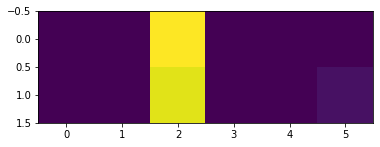

In [35]:
plt.imshow(dec_att[0,0,:])

In [36]:
dec_att[0,0,:]

tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9535, 0.0000, 0.0000, 0.0465]])